In [7]:
import h5py
import glob
import bisect
import distribution
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants
from DREAM.DREAMOutput import DREAMOutput


def newest_output(path):
    list2 = glob.glob(path + 'output_??_.h5')
    if len(list2) > 0:
        return max( glob.glob(path + 'output_??_.h5'))
    else:
        return max( glob.glob(path + 'output_?_.h5'))

# folder = "C:/Users/leferi/Documents/Egyetem/RE Projekt/Current/Data/TDK/ndc3_1000/"
# notes = "based on flat-top, isotropic hottailgrid, pmax=185 m_e*c, scraped-off material (D+T) ~1.2e24, ion diffusion coefficient 1000 m^2/s"
folder = "C:/Users/leferi/Documents/Egyetem/RE Projekt/Current/Data/TDK/ndc2_30/"
notes = "based on flat-top, isotropic hottailgrid, pmax=120 m_e*c, scraped-off material (D+T) ~1.2e24, ion diffusion coefficient 30 m^2/s"

fnames = []
try:
    newest = newest_output(folder)
    numoffiles = int(newest.split("_")[-2])
except:
    print("Finding newest output unsuccesful")
    
for i in range(1, numoffiles + 1):
    fname = folder + "output_" + str(i) + "_.h5"
    fnames.append(fname)
    
def calculate_indices(timegrid, start, ms_step):
    i = bisect.bisect_left(timegrid, start)
    if i >= len(timegrid):
        i = len(timegrid) - 1
    elif i and timegrid[i] - start > start - timegrid[i - 1]:
        i = i - 1
    else:
        i = 0
        
    frames = []
    frames.append(i) 
    
    current_time = timegrid[i] + ms_step 
    j = i
    while i < len(timegrid):
        i = bisect.bisect_left(timegrid, current_time, lo=j)
        if i >= len(timegrid):
            i = len(timegrid) - 1
        elif i and timegrid[i] - current_time > current_time - timegrid[i - 1]:
            i = i - 1
            
        frames.append(i)
        current_time += ms_step
        j = i
        i += 1

    return frames
    
def calculate_indices2(timegrid, start, number):
    i = bisect.bisect_left(timegrid, start)
    if i >= len(timegrid):
        i = len(timegrid) - 1
    elif i and timegrid[i] - start > start - timegrid[i - 1]:
        i = i - 1
    else:
        i = 0
        
    frames = []
    frames.append(i) 
    
    ms_step = (timegrid[-1] - timegrid[i]) / number
    current_time = timegrid[i] + ms_step 
    j = i
    while i < len(timegrid):
        i = bisect.bisect_left(timegrid, current_time, lo=j)
        if i >= len(timegrid):
            i = len(timegrid) - 1
        elif i and timegrid[i] - current_time > current_time - timegrid[i - 1]:
            i = i - 1
            
        frames.append(i)
        current_time += ms_step
        j = i
        i += 1

    return frames

In [8]:
concat = distribution.Distribution(fnames)
endtime = '{0:.0f}'.format(concat.timegrid_ms[-1])
print(str(endtime) + " ms")
do = DREAMOutput(fnames[-1])

510 ms


In [13]:
hf.close()

In [19]:
output_file = folder + "DEMO_runaway_distribution.h5"
hf = h5py.File(output_file, 'w')
keylist = ["dr", "real_volumes_of_cells", "major_radius", "minor_radius", "radialgrid", "radialgrid_edges",
           "re_energygrid_eV"]
for key in keylist:
    hf.create_dataset(key, data=concat.__dict__[key])
    
frames = calculate_indices(concat.timegrid_ms, 0, 1)
# to cut down the first few datapoints in energy, we need to slice by the last coordinate
# Default would be this
# re_density_sparse = concat.f_re_avg_density[frames, :, :]
# Instead we do this
cutindex = 3
re_density_sparse = np.zeros((len(frames), concat.f_re_avg_density.shape[1], concat.f_re_avg_density.shape[2]))
print(re_density_sparse.shape)
re_density_sparse[:, :, cutindex:] = concat.f_re_avg_density[frames, :, cutindex:]
n_tot_sparse = concat.n_tot[frames, :]
n_re_sparse = concat.n_re[frames, :]
timegrid_sparse = concat.timegrid_ms[frames]

hf.create_dataset("dn_over_dEdr", data=re_density_sparse)
hf.create_dataset("timegrid_ms", data=timegrid_sparse)
hf.create_dataset("n_tot", data=n_tot_sparse)
hf.create_dataset("n_re", data=n_re_sparse)
hf.create_dataset("notes", data=notes)
hf.close()

(512, 20, 120)


<class 'numpy.float64'>


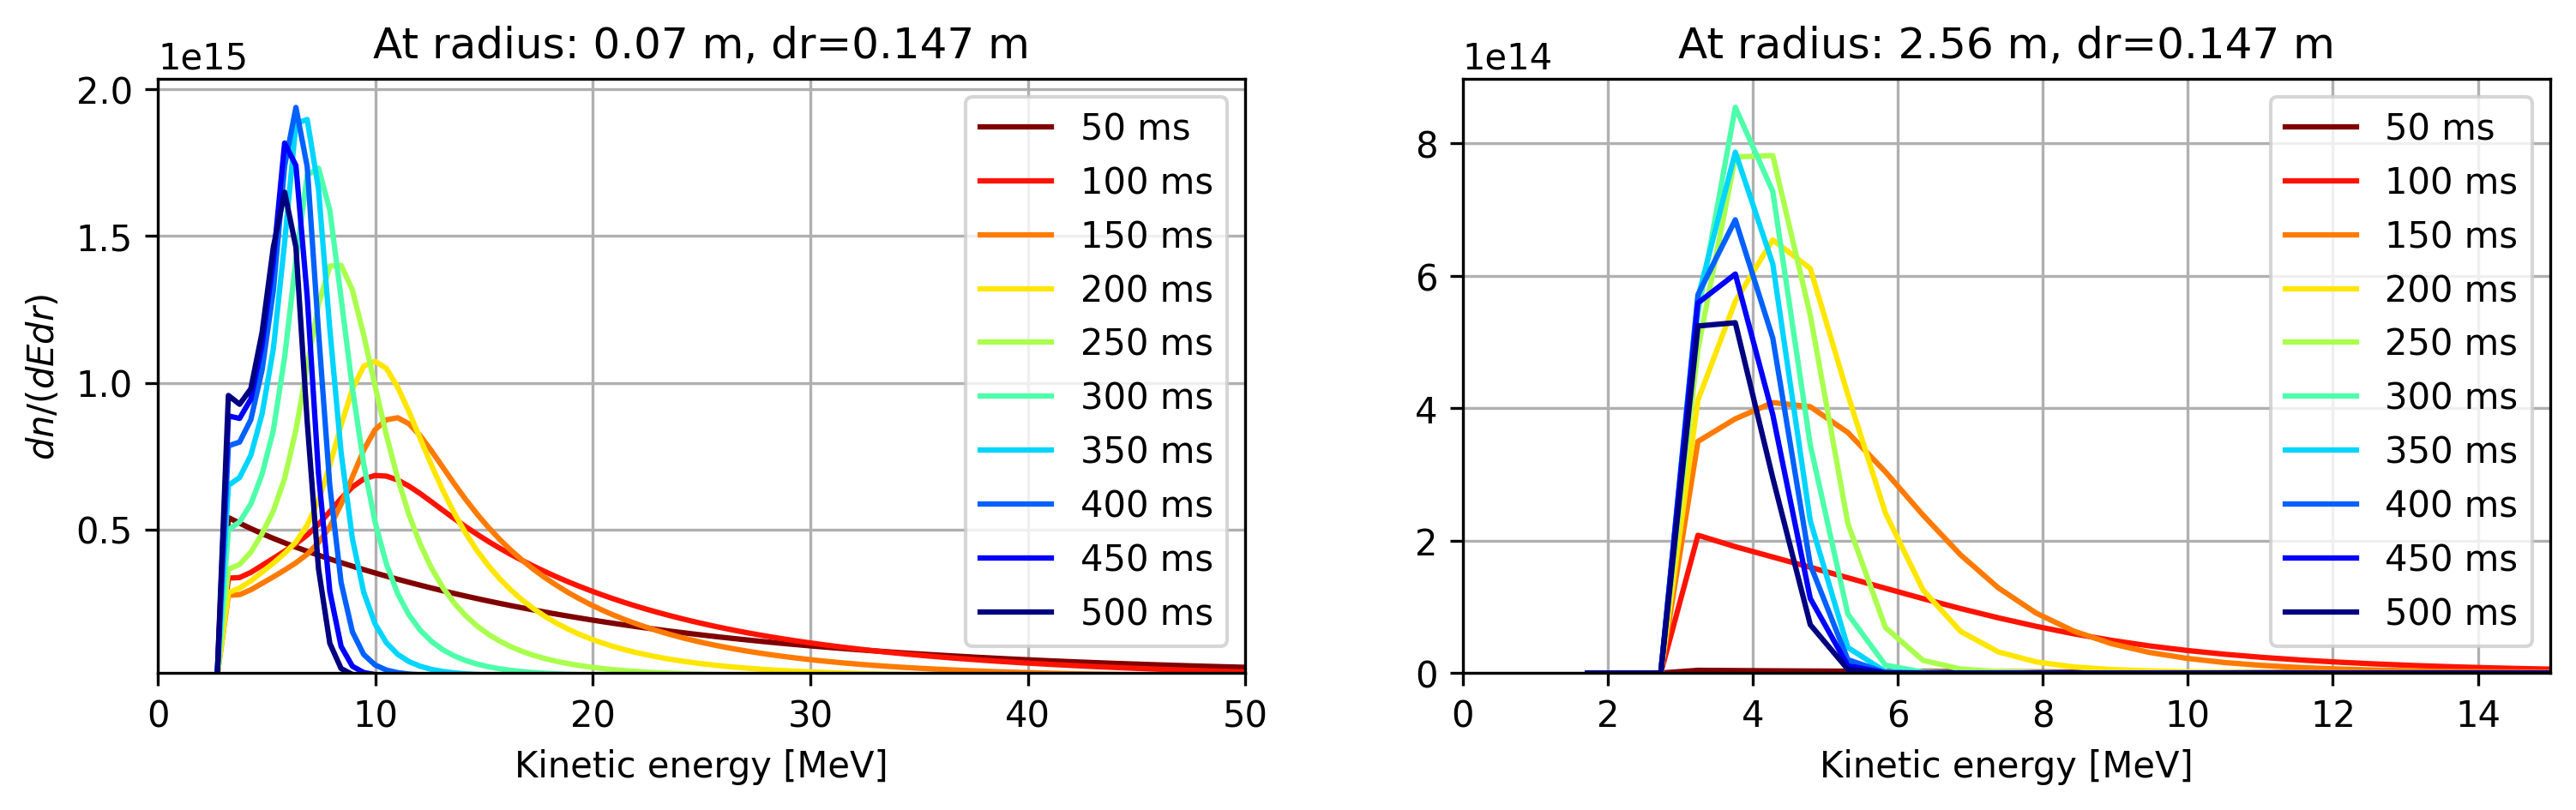

In [23]:
hf = h5py.File(output_file, 'r')
timegrid = hf["timegrid_ms"][()]
radialgrid = hf["radialgrid"][()]
dr = hf["dr"][()][0]

print(type(dr))

# Change the radial cell here from 0 to 19
radial_cell_1 = 0
radial_cell_2 = 17

if True:
    indices = calculate_indices(timegrid, 50, 50)[:-1]
    ccolors = plt.cm.jet(np.linspace(1, 0, len(indices)))

    xdata = hf["re_energygrid_eV"][()]/1e6
    ydata = hf["dn_over_dEdr"][()]
    fig = plt.figure(figsize=(12, 3), dpi=300)
    plt.subplot(1, 2, 1)  # rows, columns, index
    j = 0
    for i in indices:
        plt.plot(xdata, ydata[i, radial_cell_1, :], label='{0:.0f}'.format(np.round(timegrid[i], 0))+" ms", 
                 color=ccolors[j])
        j += 1

    plt.ylabel(r'$dn/(dEdr)$')
    plt.xlabel(r'Kinetic energy [MeV]')
    plt.title(r'At radius: ' + '{0:.2f}'.format(radialgrid[radial_cell_1]) + " m, dr="
              + '{0:.3f}'.format(dr) + " m")
    plt.tick_params('x', labelbottom=True)

    plt.ylim(1e13, None)
    plt.xlim(0, 50)
    # plt.yscale("log")
    plt.legend()
    plt.grid()

    #fig = plt.figure(figsize=(8, 5))
    plt.subplot(1, 2, 2)  # rows, columns, index
    j = 0
    for i in indices:
        plt.plot(xdata, ydata[i, radial_cell_2, :], label='{0:.0f}'.format(np.round(timegrid[i], 0))+" ms", 
                 color=ccolors[j])
        j += 1

    #plt.ylabel(r'$dn/(dEdr)$')
    plt.xlabel(r'Kinetic energy [MeV]')
    plt.title(r'At radius: ' + '{0:.2f}'.format(radialgrid[radial_cell_2]) + " m, dr="
              + '{0:.3f}'.format(dr) + " m")
    plt.tick_params('x', labelbottom=True)

    plt.ylim(0, None)
    plt.xlim(0, 15)
    #plt.yscale("log")
    plt.legend()
    plt.grid()
    
hf.close()

In [ ]:
hf = h5py.File(output_file, 'r')
timegrid = concat.timegrid_ms
radialgrid = concat.radialgrid
dr = hf["dr"][()]

# Change the radial cell here from 0 to 19
radial_cell_1 = 0
radial_cell_2 = 17

if True:
    indices = calculate_indices2(timegrid, 60, 7)
    ccolors = plt.cm.jet(np.linspace(1, 0, len(indices)))

    xdata = concat.re_momentumgrid
    ydata = concat.f_re_avg
    fig = plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)  # rows, columns, index
    j = 0
    for i in indices:
        plt.plot(xdata, ydata[i, radial_cell_1, :], label='{0:.0f}'.format(np.round(timegrid[i], 0))+" ms", 
                 color=ccolors[j])
        j += 1

    plt.ylabel(r'$\langle f_{RE}\rangle$')
    plt.xlabel(r'Momentum normalized to m$_e$c [-]')
    plt.title(r'At radius: ' + '{0:.2f}'.format(radialgrid[radial_cell_1]) + " m, dr="
              + '{0:.3f}'.format(dr[radial_cell_1]) + " m")
    plt.tick_params('x', labelbottom=True)

    plt.ylim(0, None)
    plt.xlim(0, 61.32)
    #plt.yscale("log")
    plt.legend()
    plt.grid()
    

    indices = calculate_indices2(timegrid, 60, 7)
    ccolors = plt.cm.jet(np.linspace(1, 0, len(indices)))

    xdata = concat.re_momentumgrid
    ydata = concat.f_re_avg
    #fig = plt.figure(figsize=(8, 5))
    plt.subplot(1, 2, 2)  # rows, columns, index
    j = 0
    for i in indices:
        plt.plot(xdata, ydata[i, radial_cell_2, :], label='{0:.0f}'.format(np.round(timegrid[i], 0))+" ms", 
                 color=ccolors[j])
        j += 1

    #plt.ylabel(r'$dn/(dEdr)$')
    plt.xlabel(r'Momentum normalized to m$_e$c [-]')
    plt.title(r'At radius: ' + '{0:.2f}'.format(radialgrid[radial_cell_2]) + " m, dr="
              + '{0:.3f}'.format(dr[radial_cell_2]) + " m")
    plt.tick_params('x', labelbottom=True)

    plt.ylim(0, None)
    plt.xlim(0, 61.32)
    #plt.yscale("log")
    plt.legend()
    plt.grid()
    
hf.close()

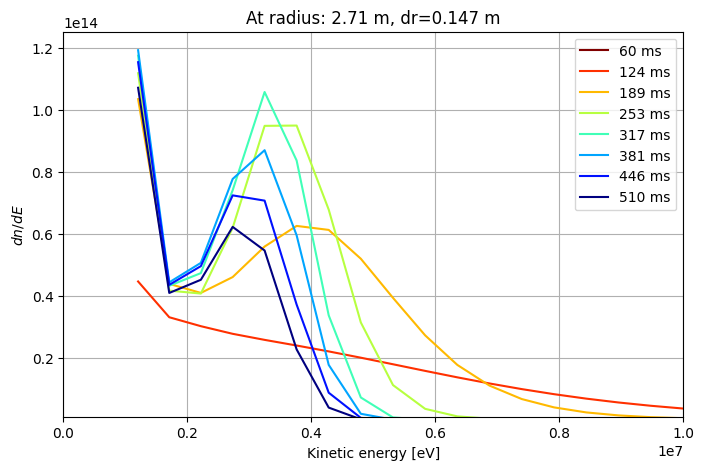

In [32]:
hf = h5py.File(output_file, 'r')
timegrid = hf["timegrid"][()]
radialgrid = hf["radialgrid"][()]
dr = hf["dr"][()]
if True:
    indices = calculate_indices2(timegrid * 1000, 60, 7)
    ccolors = plt.cm.jet(np.linspace(1, 0, len(indices)))
    radial_cell = 18

    xdata = hf["re_energygrid_eV"][()]
    ydata = hf["dn_over_dEdr"][()]
    fig = plt.figure(figsize=(8, 5))
    plt.subplot(1, 1, 1)  # rows, columns, index
    j = 0
    for i in indices:
        plt.plot(xdata, ydata[i, radial_cell, :] * dr[radial_cell],
                 label='{0:.0f}'.format(np.round(timegrid[i] * 1000, 0))+" ms", 
                 color=ccolors[j])
        j += 1

    plt.ylabel(r'$dn/dE$')
    plt.xlabel(r'Kinetic energy [eV]')
    plt.title(r'At radius: ' + '{0:.2f}'.format(radialgrid[radial_cell]) + " m, dr="
              + '{0:.3f}'.format(dr[radial_cell]) + " m")
    plt.tick_params('x', labelbottom=True)

    plt.ylim(1e12, None)
    plt.xlim(0, 1e7)
    #plt.yscale("log")
    plt.legend()
    plt.grid()
    
hf.close()

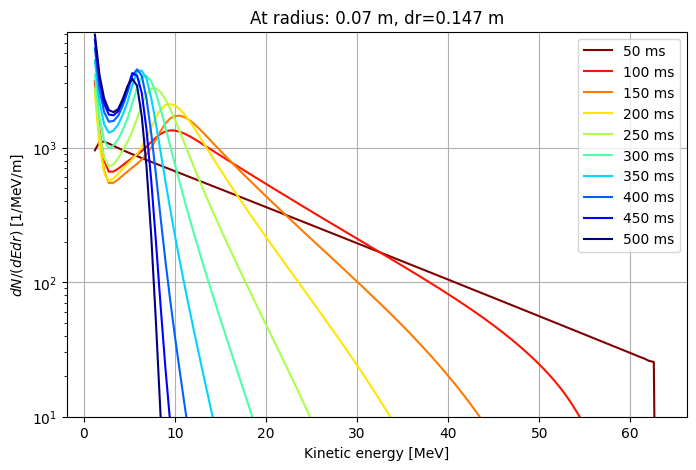

In [13]:
indices = calculate_indices(concat.timegrid_ms, 50, 50)[:-1]
ccolors = plt.cm.jet(np.linspace(1, 0, len(indices)))

xdata = (concat.re_energygrid_eV - 510998.95) / 1e6
ydata = concat.dnOverdrdE * (scipy.constants.e / 1e6)
fig = plt.figure(figsize=(8, 5))
plt.subplot(1, 1, 1)  # rows, columns, index
j = 0
cell = 0
for i in indices:
    plt.plot(xdata, ydata[i, cell, :], label='{0:.0f}'.format(np.round(concat.timegrid_ms[i], 0))+" ms", 
                color=ccolors[j])
    j += 1

plt.ylabel(r'$dN/(dEdr) \;\rm[1/MeV/m]$')
plt.xlabel(r'Kinetic energy [MeV]')
plt.title(r'At radius: ' + '{0:.2f}'.format(concat.radialgrid[cell]) + " m, dr="
            + '{0:.3f}'.format(concat.dr[cell]) + " m")
plt.tick_params('x', labelbottom=True)


plt.ylim(10, None)
plt.yscale("log")
plt.legend()
plt.grid()
plt.show()

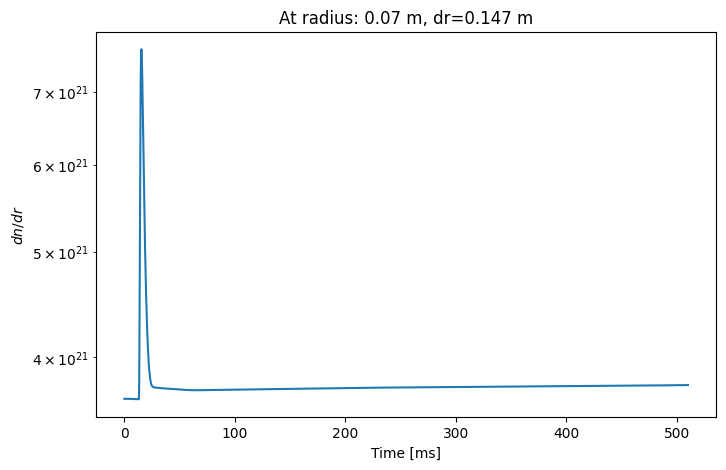

In [4]:
cell = 0
fig = plt.figure(figsize=(8, 5)) 
plt.plot(concat.timegrid_ms, concat.n_re[:, cell]/concat.dnOverdr[:, cell])
#plt.plot(concat.timegrid_ms, concat.dnOverdr[:, cell])

plt.ylabel(r'$dn/dr$')
plt.xlabel(r'Time [ms]')
plt.title(r'At radius: ' + '{0:.2f}'.format(concat.radialgrid[cell]) + " m, dr="
            + '{0:.3f}'.format(concat.dr[cell]) + " m")
plt.tick_params('x', labelbottom=True)
plt.yscale("log")
plt.show()

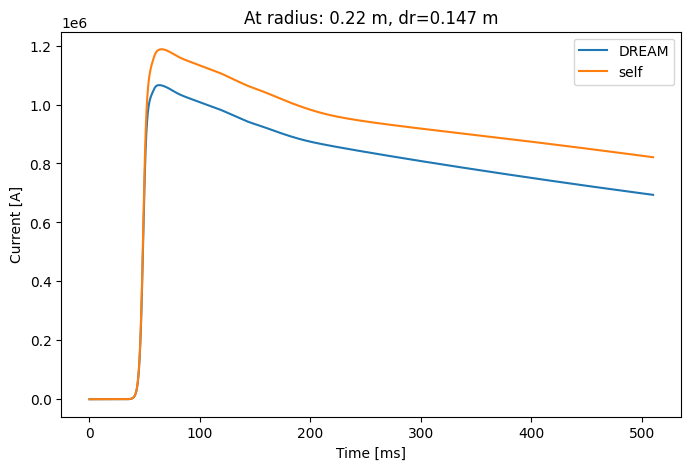

In [32]:
cell = 1
fig = plt.figure(figsize=(8, 5)) 
values1 = concat.f_re_current_density[:, cell, :].sum(axis=1) 
values2 = concat.dnOverdr[:, cell] * scipy.constants.c * scipy.constants.e #*concat.real_volumes_of_cells[cell]  # no need to multiply with VpVol, because it's in the angle averaging
values3 = concat.alternate_current[:, cell]
plt.plot(concat.timegrid_ms, values1, label="DREAM")
plt.plot(concat.timegrid_ms, values2, label="self")

plt.ylabel(r'Current density [A/m^2]')
plt.xlabel(r'Time [ms]')
plt.title(r'At radius: ' + '{0:.2f}'.format(concat.radialgrid[cell]) + " m, dr="
            + '{0:.3f}'.format(concat.dr[cell]) + " m")
plt.tick_params('x', labelbottom=True)
plt.legend()
#plt.yscale("log")
plt.show()
#print(concat.velocity_grid)

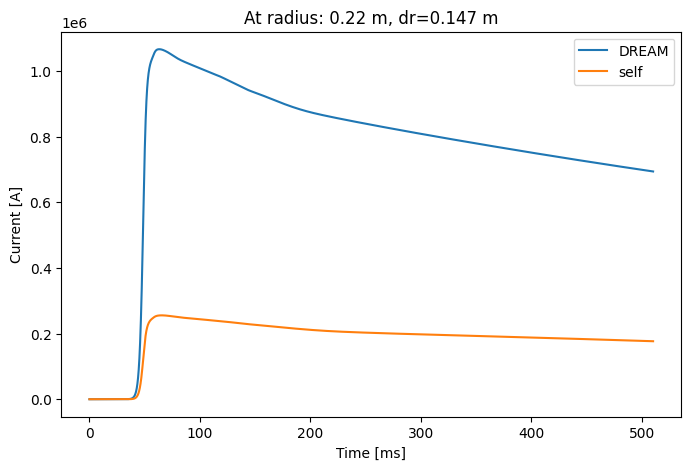

In [34]:
cell = 1
fig = plt.figure(figsize=(8, 5)) 
values1 = concat.f_re_current_density[:, cell, :].sum(axis=1) 
values2 = concat.dnOverdr[:, cell] * scipy.constants.c * scipy.constants.e * concat.real_volumes_of_cells[cell] / (2*np.pi*8.9) # no need to multiply with VpVol, because it's in the angle averaging
values3 = concat.alternate_current[:, cell]
plt.plot(concat.timegrid_ms, values1, label="DREAM")
plt.plot(concat.timegrid_ms, values2, label="self")

plt.ylabel(r'Current [A]')
plt.xlabel(r'Time [ms]')
plt.title(r'At radius: ' + '{0:.2f}'.format(concat.radialgrid[cell]) + " m, dr="
            + '{0:.3f}'.format(concat.dr[cell]) + " m")
plt.tick_params('x', labelbottom=True)
plt.legend()
#plt.yscale("log")
plt.show()
#print(concat.velocity_grid)

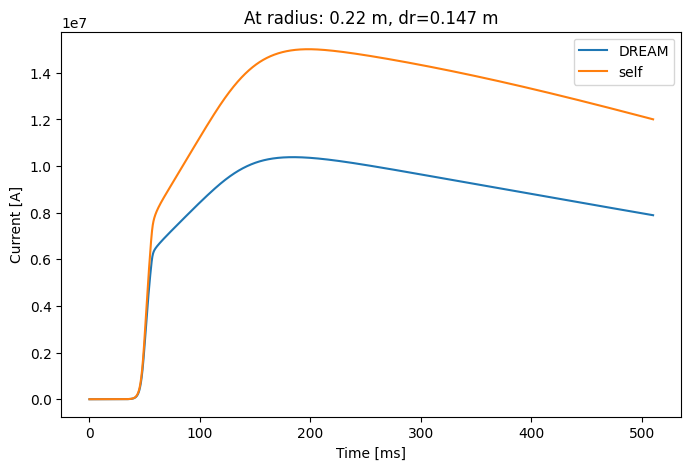

In [14]:
cell = 1
fig = plt.figure(figsize=(8, 5)) 
values1 = concat.I_re
values2 = np.sum(concat.dnOverdr[:, :] * scipy.constants.c * scipy.constants.e * concat.real_volumes_of_cells[:] / (2*np.pi*7), axis=1) # no need to multiply with VpVol, because it's in the angle averaging
values3 = concat.alternate_current[:, cell]
values4 = do.grid.integrate(concat.dnOverdr[:, :], w=((do.grid.GR0/do.grid.Bmin) * do.grid.FSA_R02OverR2)) * scipy.constants.c * scipy.constants.e / (2*np.pi)
plt.plot(concat.timegrid_ms, values1, label="DREAM")
plt.plot(concat.timegrid_ms, values4, label="self")

plt.ylabel(r'Current [A]')
plt.xlabel(r'Time [ms]')
plt.title(r'At radius: ' + '{0:.2f}'.format(concat.radialgrid[cell]) + " m, dr="
            + '{0:.3f}'.format(concat.dr[cell]) + " m")
plt.tick_params('x', labelbottom=True)
plt.legend()
#plt.yscale("log")
plt.show()
#print(concat.velocity_grid)

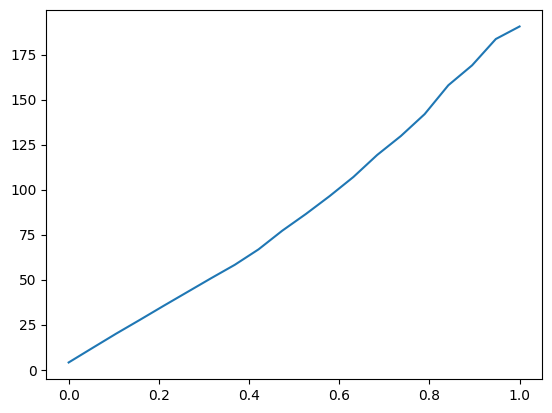

In [31]:
plt.plot(np.linspace(0, 1, 20), concat.real_volumes_of_cells)

In [2]:
def GammafluxProfil(E, C1=1.2, C2=0.8, C3=0.):
    mc2 = 0.51099895000e6
    z = (np.log(mc2 * E / 1e6) + C1) / C2 + C3 * (mc2 * E / 1e6)**2
    Gamma = np.exp(-np.exp(-z) - z + 1)
    return Gamma

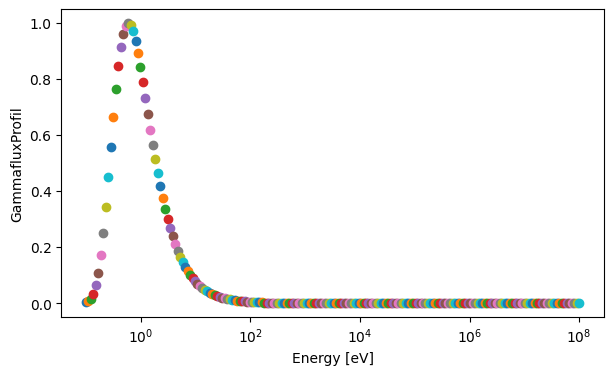

In [9]:
energyrange = np.logspace(-1, 8, 200, base=10)

fig, ax = plt.subplots(1, 1, figsize=[7,4])

for energy in energyrange:
    ax.scatter(energy, GammafluxProfil(energy))

ax.set_xscale("log")
#ax.set_yscale("log")
ax.set_xlabel("Energy [eV]")
ax.set_ylabel("GammafluxProfil")
plt.show()